In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from utils import get_params, get_vocab
import random as r

In [5]:
# Define the paths to the vocabulary, tags, and data files
vocab_path = r'data\large\words.txt'  # Path to the vocabulary file
tags_path = r'C:\Personal\Projects\NLP\NER\data\large\tags.txt'  # Path to the tags file

# Load the vocabulary and tag mapping
vocab, tag_map = get_vocab(vocab_path, tags_path)  # Function to read vocabulary and tags from files

# Create a reverse mapping of tags to their numerical indices
map_tag = {m:t for t,m in tag_map.items()}  # Reverse the tag mapping dictionary
map_tag  # Print the reversed tag mapping

# Define the paths to the training, validation, and test data files
train_sentences_file = r'data\large\train\sentences.txt'  # Path to training sentences file
train_labels_file = r'data\large\train\labels.txt'  # Path to training labels file

val_sentences_file = r'data\large\val\sentences.txt'  # Path to validation sentences file
val_labels_file = r'data\large\val\labels.txt'  # Path to validation labels file

test_sentences_file = r'data\large\test\sentences.txt'  # Path to test sentences file
test_labels_file = r'data\large\test\labels.txt'  # Path to test labels file

# Load the data for training, validation, and testing
train_sentences, train_labels, train_size = get_params(vocab, tag_map, train_sentences_file, train_labels_file) 
val_sentences, val_labels, val_size = get_params(vocab, tag_map, val_sentences_file, val_labels_file)
test_sentences, test_labels, test_size = get_params(vocab, tag_map, test_sentences_file, test_labels_file)


In [3]:
def data_generator(X, Y, batch_size = None, shuffle = True):
    
    if len(X) != len(Y):
        raise Exception("Length of X and Y should be of the same length")
    
    if batch_size == None:
        batch_size = len(X)
    elif batch_size > len(X):
        raise Exception("batch size should be less than Length of X")
    
    indexes = [*range(len(X))]
    if shuffle:
        r.shuffle(indexes)
    
    buffer_x = [0]*batch_size
    buffer_y = [0]*batch_size
    
    max_length = 0
    
    for i in range(batch_size):
        buffer_x[i] = X[indexes[i]]
        buffer_y[i] = Y[indexes[i]]
        max_length = max(len(X[indexes[i]]), max_length)
    
    for index, (sentence, label) in enumerate(zip(buffer_x, buffer_y)):
        pad_length = max_length - len(sentence)
        buffer_x[index] = sentence + [vocab['<PAD>']] * pad_length
        buffer_y[index] = label + [vocab['<PAD>']] * pad_length
    
    buffer_x = torch.tensor(buffer_x)
    buffer_y = torch.tensor(buffer_y)
    
    return buffer_x, buffer_y

In [184]:
class NER(nn.Module):
    def __init__(self, vocab_length, n_embedding, n_hidden, n_classes) -> None:
        super().__init__()
        
        self.emdedding = nn.Embedding(vocab_length, n_embedding)
        self.lstm = nn.LSTM(n_embedding, hidden_size = n_hidden, batch_first=True)
        self.dense = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x):
        x = self.emdedding(x)
        x, _ = self.lstm(x)
        logits = self.dense(x)
        
        return logits
        

In [250]:
def model_train(X, Y, batch_size, epochs, learning_rate, NNmodel):
    
    interval = epochs // 10
    optimizer = optim.Adam(NNmodel.parameters(), learning_rate)
    NNmodel.train()
    for epoch in range(epochs):
        X_batch, Y_batch = data_generator(X, Y, batch_size = batch_size)
        logits = NNmodel.forward(X_batch)

        logits = logits.view(-1, len(tag_map))  # Shape: (batch_size * seq_length, num_classes)
        Y_batch = Y_batch.view(-1)   
        loss = F.cross_entropy(logits, Y_batch, ignore_index = vocab['<PAD>'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % interval == 0:
            print(f'Loss at epoch {epoch} ====> {loss}')
    
    return loss, logits

In [251]:
vocab_length = len(vocab)
n_embedding = 8
n_hidden = 8
n_classes = len(tag_map)

model = NER(vocab_length, n_embedding, n_hidden, n_classes)

In [252]:
print(model)
print(f'total trainable weights = {sum([parameter.nelement()for parameter in model.parameters()])}')

NER(
  (emdedding): Embedding(35181, 8)
  (lstm): LSTM(8, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=17, bias=True)
)
total trainable weights = 282177


In [253]:
loss, logits = model_train(train_sentences, train_labels, batch_size=32, learning_rate = 0.01, epochs = 5000, NNmodel=model)
loss

Loss at epoch 0 ====> 2.7507247924804688
Loss at epoch 500 ====> 0.39821988344192505
Loss at epoch 1000 ====> 0.3311210870742798
Loss at epoch 1500 ====> 0.21176479756832123
Loss at epoch 2000 ====> 0.2204662561416626
Loss at epoch 2500 ====> 0.15319885313510895
Loss at epoch 3000 ====> 0.0828745886683464
Loss at epoch 3500 ====> 0.17982468008995056
Loss at epoch 4000 ====> 0.07337985932826996
Loss at epoch 4500 ====> 0.10538975149393082


tensor(0.1188, grad_fn=<NllLossBackward0>)

In [254]:
@torch.no_grad()
def evaluate(split):
    x, y = {'train': (train_sentences, train_labels), 
            'val': (val_sentences, val_labels),
            'test': (test_sentences, test_labels)}[split]
    
    x, y = data_generator(x, y)
    logits = model.forward(x)
    preds = F.softmax(logits, dim = 2)
    preds = torch.argmax(preds, dim = 2)
    
    mask = y != vocab['<PAD>']
    accuracy = torch.sum(preds == y)/float(torch.sum(mask)) *100
    
    logits = logits.view(-1, len(tag_map))  # Shape: (batch_size * seq_length, num_classes)
    y = y.view(-1) 
    loss = F.cross_entropy(logits, y, ignore_index = vocab['<PAD>'])
    
    print(f'{split} Loss = {loss:.2f}, {split} Accuracy = {accuracy:.2f}')
    return None

In [255]:
evaluate('train')
evaluate('val')
evaluate('test')

train Loss = 0.10, train Accuracy = 96.89
val Loss = 0.17, val Accuracy = 95.28
test Loss = 0.17, test Accuracy = 95.32


#### Model - 1
* n_embedding = 3
* n_hidden = 10

1. train Loss = 0.11, train Accuracy = 96.74
2. val Loss = 0.17, val Accuracy = 95.22
3. test Loss = 0.17, test Accuracy = 95.21

#### Model - 2
* n_embedding = 10
* n_hidden = 10

1. train Loss = 0.10, train Accuracy = 97.03
2. val Loss = 0.17, val Accuracy = 95.39
3. test Loss = 0.17, test Accuracy = 95.35


#### Model - 3
* n_embedding = 10
* n_hidden = 1

1. train Loss = 0.32, train Accuracy = 88.84
2. val Loss = 0.35, val Accuracy = 88.43
3. test Loss = 0.36, test Accuracy = 88.19

#### Model - 4
* n_embedding = 50
* n_hidden = 1

1. train Loss = 0.34, train Accuracy = 88.48
2. val Loss = 0.37, val Accuracy = 88.21
3. test Loss = 0.38, test Accuracy = 87.99


#### Model - 5
* n_embedding = 50
* n_hidden = 5

#### Model - 6
* n_embedding = 3
* n_hidden = 10

1. train Loss = 0.11, train Accuracy = 96.74
2. val Loss = 0.17, val Accuracy = 95.22
3. test Loss = 0.17, test Accuracy = 95.21

#### Model - 7
* n_embedding = 10
* n_hidden = 10

1. train Loss = 0.10, train Accuracy = 97.03
2. val Loss = 0.17, val Accuracy = 95.39
3. test Loss = 0.17, test Accuracy = 95.35

#### Model - 8
* n_embedding = 5
* n_hidden = 5

1. train Loss = 0.14, train Accuracy = 96.27
2. val Loss = 0.20, val Accuracy = 94.83
3. test Loss = 0.20, test Accuracy = 94.80

#### Model 9
* n_embedding = 8
* n_hidden = 8

1. train Loss = 0.10, train Accuracy = 96.89
2. val Loss = 0.17, val Accuracy = 95.28
3. test Loss = 0.17, test Accuracy = 95.32




In [347]:
def preprocess(sentence):
    x = []
    sentence = sentence.split()
    for word in sentence:
        if word not in vocab:
            x.append(vocab['UNK'])
        else:
            x.append(vocab[word])
    x = torch.tensor(x)
    return x


def predict(sentence, model):
    x = preprocess(sentence)
    logits = model.forward(x)
    preds = F.softmax(logits, dim = 1)
    preds = torch.argmax(preds, dim = 1)
    result = []
    for pred, word in zip(preds,sentence.split()):
        print(f'{word} ===> {map_tag[pred.item()]}')
        result.append(map_tag[pred.item()])
    return result

In [348]:
sentence = 'Apple Inc. was founded by Steve Jobs, Steve Wozniak, and Ronald Wayne in Cupertino on April 1, 1976'
predict(sentence, model)

Apple ===> B-org
Inc. ===> I-org
was ===> O
founded ===> O
by ===> O
Steve ===> B-per
Jobs, ===> I-per
Steve ===> I-per
Wozniak, ===> I-per
and ===> O
Ronald ===> B-per
Wayne ===> I-per
in ===> O
Cupertino ===> B-geo
on ===> O
April ===> B-tim
1, ===> O
1976 ===> B-tim


['B-org',
 'I-org',
 'O',
 'O',
 'O',
 'B-per',
 'I-per',
 'I-per',
 'I-per',
 'O',
 'B-per',
 'I-per',
 'O',
 'B-geo',
 'O',
 'B-tim',
 'O',
 'B-tim']

In [256]:
embeddings = list(model.parameters())[0]
embeddings

Parameter containing:
tensor([[-1.8328, -0.2203, -0.0349,  ...,  1.0065, -2.0557, -0.6600],
        [-0.4040,  0.1135, -2.4227,  ...,  2.2720, -0.1379,  0.4258],
        [ 0.5370,  2.0942, -0.4447,  ...,  1.3729, -0.8314, -0.1243],
        ...,
        [-0.9222,  1.0555, -0.8333,  ..., -0.1270, -1.3742,  0.5358],
        [-1.7196, -0.6844,  0.5919,  ..., -0.6999,  0.2910, -0.3639],
        [-1.4225,  0.4762,  0.5507,  ...,  0.6846, -0.8338, -0.1449]],
       requires_grad=True)

In [257]:
from sklearn.decomposition import PCA #Import PCA from scikit-learn
pca = PCA(n_components=2) #PCA with two dimensions

with torch.no_grad():
    emb_2dim = pca.fit_transform(embeddings)

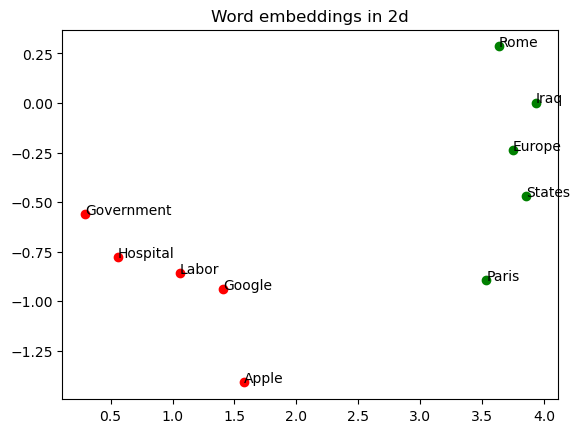

In [342]:
%matplotlib inline
import matplotlib.pyplot as plt

#Selection of negative and positive words
neg_words = ['Google', 'Apple', 'Hospital', 'Labor', 'Government']
pos_words = ['Iraq', 'Paris', 'Rome', 'States', 'Europe']

#Index of each selected word
neg_n = [vocab[w] for w in neg_words]
pos_n = [vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(emb_2dim[neg_n][:,0],emb_2dim[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (emb_2dim[neg_n][i,0],emb_2dim[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(emb_2dim[pos_n][:,0],emb_2dim[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(emb_2dim[pos_n][i,0],emb_2dim[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()